In [545]:
# import necessary libraries
import pandas as pd
import pystan as stan
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import and Pre-processing data

Since the originial dataset does not contains neighborhoods, I manully added the corresponding neighborhood to each response. For Argentina, I used the neighborhood classfication given by the professor, for Taipei, since neighborhood name is not given, I classfied stores into corresponding neighbors according to their districts.

In [546]:
#import data, and edit the header
data = pd.read_csv('CS146 Data Revised.csv',names=['Timestamp',
                     'Email Address', 'Your Name', 
                     'Store', 'Address', 
                     'Apples_1_quant', 'Apples_1_price',
                     'Apples_2_quant', 'Apples_2_price',
                     'Apples_3_quant', 'Apples_3_price',
                     'Bananas_1_quant', 'Bananas_1_price',
                     'Bananas_2_quant', 'Bananas_2_price',
                     'Bananas_3_quant', 'Bananas_3_price',
                     'Tomatoes_1_quant', 'Tomatoes_1_price',
                     'Tomatoes_2_quant', 'Tomatoes_2_price',
                     'Tomatoes_3_quant', 'Tomatoes_3_price',
                     'Potatoes_1_quant', 'Potatoes_1_price',
                     'Potatoes_2_quant', 'Potatoes_2_price',
                     'Potatoes_3_quant', 'Potatoes_3_price',
                     'Flour_1_quant', 'Flour_1_price',
                     'Flour_2_quant', 'Flour_2_price',
                     'Flour_3_quant', 'Flour_3_price',
                     'Rice_1_quant', 'Rice_1_price',
                     'Rice_2_quant', 'Rice_2_price',
                     'Rice_3_quant', 'Rice_3_price', 
                     'Milk_1_quant', 'Milk_1_price',
                     'Milk_2_quant', 'Milk_2_price',
                     'Milk_3_quant', 'Milk_3_price',
                     'Butter_1_quant', 'Butter_1_price',
                     'Butter_2_quant', 'Butter_2_price',
                     'Butter_3_quant', 'Butter_3_price',
                     'Eggs_1_quant', 'Eggs_1_price',
                     'Eggs_2_quant', 'Eggs_2_price',
                     'Eggs_3_quant', 'Eggs_3_price',
                     'Chicken_1_quant', 'Chicken_1_price',
                     'Chicken_2_quant', 'Chicken_2_price',
                     'Chicken_3_quant', 'Chicken_3_price',
                     'Area'],header=0)

In [547]:
# take a look at the data
data.head(3)

Timestamp                 Email Address                Your Name  \
0  3/2/20 19:09  antoniostark@minerva.kgi.edu            Antonio Stark   
1  3/2/20 23:33      halkenjo@minerva.kgi.edu  Johannes Halkenhaeusser   
2  3/2/20 23:37      halkenjo@minerva.kgi.edu  Johannes Halkenhaeusser   

                Store                                            Address  \
0            Wellcome  Wellcome, No. 145, Section 1, Heping East Road...   
1           Carrefour  Carrefour Market, Av. Corrientes 1160, 1043 CA...   
2  Supermercados DÃ­a  Supermercados DÃ­a, Av. Corrientes 3534, C1194...   

   Apples_1_quant  Apples_1_price  Apples_2_quant  Apples_2_price  \
0             0.6          198.00             0.4           138.0   
1             1.0           69.90             1.0            86.0   
2             1.0           74.99             NaN             NaN   

   Apples_3_quant  ...  Eggs_2_price  Eggs_3_quant  Eggs_3_price  \
0             1.2  ...         96.00          10.0        158.00   
1             1.0  ...          9.17           1.0         10.25   
2             NaN  ...          9.17           1.0         11.33   

   Chicken_1_quant  Chicken_1_price  Chicken_2_quant  Chicken_2_price  \
0             0.16            198.0             0.25            158.0   
1             1.00            239.9             1.00            304.9   
2             1.00            312.9              NaN              NaN   

   Chicken_3_quant  Chicken_3_price     Area  
0              0.1             50.0     Daan  
1              NaN              NaN   Retiro  
2              NaN              NaN  Almagro  

[3 rows x 66 columns]

In [548]:
# drop timestamp, email, and name, as they are irrelevant for our analysis
data.drop(columns=['Timestamp','Email Address','Your Name'], 
          inplace = True)

In [549]:
data.head(3)

Store                                            Address  \
0            Wellcome  Wellcome, No. 145, Section 1, Heping East Road...   
1           Carrefour  Carrefour Market, Av. Corrientes 1160, 1043 CA...   
2  Supermercados DÃ­a  Supermercados DÃ­a, Av. Corrientes 3534, C1194...   

   Apples_1_quant  Apples_1_price  Apples_2_quant  Apples_2_price  \
0             0.6          198.00             0.4           138.0   
1             1.0           69.90             1.0            86.0   
2             1.0           74.99             NaN             NaN   

   Apples_3_quant  Apples_3_price  Bananas_1_quant  Bananas_1_price  ...  \
0             1.2           478.0             0.14             20.0  ...   
1             1.0            50.0             1.00             94.9  ...   
2             NaN             NaN              NaN              NaN  ...   

   Eggs_2_price  Eggs_3_quant  Eggs_3_price  Chicken_1_quant  Chicken_1_price  \
0         96.00          10.0        158.00             0.16            198.0   
1          9.17           1.0         10.25             1.00            239.9   
2          9.17           1.0         11.33             1.00            312.9   

   Chicken_2_quant  Chicken_2_price  Chicken_3_quant  Chicken_3_price     Area  
0             0.25            158.0              0.1             50.0     Daan  
1             1.00            304.9              NaN              NaN   Retiro  
2              NaN              NaN              NaN              NaN  Almagro  

[3 rows x 63 columns]

In [550]:
# look at how many different store brands we have
data["Store"].unique()

array(['Wellcome', 'Carrefour', 'Supermercados DÃ\xada', 'Jumbo',
       'Safeway', 'Safeway '], dtype=object)

In [551]:
# drop the Safeway samples in San Francisco, since the sample size is too small, and the study will only
# focus on two cities: Taipei and BA
data = data.drop(data[data['Store'] == 'Safeway '].index).drop(
        data[data['Store'] == 'Safeway'].index)

In [552]:
# recheck the drop has been successful
data["Store"].unique()

array(['Wellcome', 'Carrefour', 'Supermercados DÃ\xada', 'Jumbo'],
      dtype=object)

In [553]:
# normalizing the price by dividing the price with quantity
# extra quantities and prices data
quantities = data.loc[:, data.columns.str.contains('quant')]
prices = data.loc[:, data.columns.str.contains('price')]

In [554]:
labels = ['Apples1', 'Apples2', 'Apples3',
         'Bananas1', 'Bananas2', 'Bananas3',
         'Tomatoes1', 'Tomatoes2', 'Tomatoes3',
         'Potatoes1', 'Potatoes2', 'Potatoes3',
         'Flour1', 'Flour2', 'Flour3',
         'Rice1', 'Rice2', 'Rice3',
         'Milk1', 'Milk2', 'Milk3',
         'Butter1', 'Butter2', 'Butter3',
         'Eggs1', 'Eggs2', 'Eggs3',
         'Chicken1', 'Chicken2', 'Chicken3']

In [555]:
# rename columns to use the divide funciton in Pandas
quantities.columns = labels
prices.columns = labels
# creat an new dataframe containing normalized prices
Normalized_data = prices.divide(quantities, axis='columns')

In [556]:
# have a look at the normalized price 
Normalized_data.head()

Apples1  Apples2     Apples3    Bananas1  Bananas2  Bananas3  Tomatoes1  \
0   330.00    345.0  398.333333  142.857143       NaN       NaN     316.00   
1    69.90     86.0   50.000000   94.900000       NaN       NaN      84.90   
2    74.99      NaN         NaN         NaN       NaN       NaN      92.99   
3    80.00      NaN         NaN   84.000000       NaN       NaN      99.00   
4    69.00     89.0  159.000000   84.000000       NaN       NaN      99.00   

   Tomatoes2  Tomatoes3   Potatoes1  ...   Milk3  Butter1  Butter2  Butter3  \
0     236.00      272.0  196.666667  ...  178.60  1626.00  1700.00   2544.0   
1        NaN        NaN   26.000000  ...  218.50   545.00   525.00    680.0   
2      92.99        NaN   34.990000  ...   68.99   489.98   497.45    532.9   
3     139.00      109.0   44.000000  ...   65.00   625.00   650.00    470.0   
4     109.00      139.0   39.000000  ...   69.00   690.00   623.50    650.0   

       Eggs1      Eggs2      Eggs3  Chicken1  Chicken2  Chicken3  
0  19.000000   9.600000  15.800000    1237.5     632.0     500.0  
1   9.830000   9.170000  10.250000     239.9     304.9       NaN  
2   9.830000   9.170000  11.330000     312.9       NaN       NaN  
3  15.483333   9.833333  13.816667     293.9     348.9       NaN  
4  15.416667  12.083333   8.250000     372.0       NaN       NaN  

[5 rows x 30 columns]

In [557]:
# add corresponding store and area to the new dataframe with normalized price
Normalized_data['Store'] = data.Store
Normalized_data['Area'] = data.Area
Normalized_data.head(3)

Apples1  Apples2     Apples3    Bananas1  Bananas2  Bananas3  Tomatoes1  \
0   330.00    345.0  398.333333  142.857143       NaN       NaN     316.00   
1    69.90     86.0   50.000000   94.900000       NaN       NaN      84.90   
2    74.99      NaN         NaN         NaN       NaN       NaN      92.99   

   Tomatoes2  Tomatoes3   Potatoes1  ...  Butter2  Butter3  Eggs1  Eggs2  \
0     236.00      272.0  196.666667  ...  1700.00   2544.0  19.00   9.60   
1        NaN        NaN   26.000000  ...   525.00    680.0   9.83   9.17   
2      92.99        NaN   34.990000  ...   497.45    532.9   9.83   9.17   

   Eggs3  Chicken1  Chicken2  Chicken3               Store     Area  
0  15.80    1237.5     632.0     500.0            Wellcome     Daan  
1  10.25     239.9     304.9       NaN           Carrefour   Retiro  
2  11.33     312.9       NaN       NaN  Supermercados DÃ­a  Almagro  

[3 rows x 32 columns]

In [558]:
# Melt data so that each row is an observation of the price of one product at one store 
melt_data = pd.melt(Normalized_data, id_vars=['Store', 'Area'],
                     value_vars=labels,
                     value_name = 'Normalized_Price', var_name = 'Grocery')

In [559]:
# have a look at the dataset after melting
melt_data.head(3)

Store     Area  Grocery  Normalized_Price
0            Wellcome     Daan  Apples1            330.00
1           Carrefour   Retiro  Apples1             69.90
2  Supermercados DÃ­a  Almagro  Apples1             74.99

In [560]:
# Since we only interested in differnt grocery itself, not the further differentiation in the grocery,
# so we can merge different products of one kind of grocery
# for example, all apples_1, apples_2, apples_3 will become Apples
melt_data['Grocery'] = melt_data.Grocery.apply(lambda x: x[:-1])
melt_data.head(3)

Store     Area Grocery  Normalized_Price
0            Wellcome     Daan  Apples            330.00
1           Carrefour   Retiro  Apples             69.90
2  Supermercados DÃ­a  Almagro  Apples             74.99

In [561]:
# Transform different Stores, Areas, and Groceries into ID numbers that thay can be used in the Stan model later

def ID_generator(dataframe, column, ID):
    for i, j in enumerate(dataframe[column].unique()):
        ID[column][j] = i + 1
    
    return (ID)

ID = {}

for column in ['Store', 'Area', 'Grocery']:
    ID[column] = {}
    ID = ID_generator(melt_data, column, ID) 
    melt_data[column] = [ID[column][unique] for unique in melt_data[column]]

In [562]:
# dictionary for grocery, area, and store
grocery_dict = ID["Grocery"]
area_dict = ID["Area"]
store_dict = ID["Store"]

In [563]:
melt_data.head()

Store  Area  Grocery  Normalized_Price
0      1     1        1            330.00
1      2     2        1             69.90
2      3     3        1             74.99
3      4     4        1             80.00
4      4     2        1             69.00

In [564]:
print(melt_data.shape)

(1140, 4)


In [565]:
# drop NA values in the Normalized_Price part, otherwise Stan won't take NA values (debugged)
melt_data = melt_data.dropna(axis=0, subset=['Normalized_Price'])
print(melt_data.shape)
# as we can see, about 300 NA observations are discarded (1140->853)

(853, 4)


## Stan Model

In [579]:
stan_code = """


// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {
    int<lower=1> num_data; // number of data collected                    
    int<lower=1> num_areas; // number of areas
    int<lower=1> num_stores; // number of different store brands                
    int<lower=1> num_groceries; // number of different groceries             

    // Collected data
    real<lower=0> prices[num_data];        
    int<lower=1> areas[num_data];    
    int<lower=1> stores[num_data];          
    int<lower=1> groceries[num_data];  
    
    //fixed prior hypterparameter
    real<lower=0> alpha;
    real<lower=0> beta;
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.


parameters {
    real<lower=0> base_price[num_groceries]; // vector with base price; the number of base price is the number of different groceries                                 
    real<lower=0> multiplier_location[num_areas]; // location multiplier
    real<lower=0> multiplier_store[num_stores]; // store multiplier
    real<lower=0> sigma; // variance when sampled from the normal distribution for prices
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {
    // Priors
    sigma ~ gamma(alpha, beta); // generating random variances for the normal distribution
    base_price ~ cauchy(1,2);//cauchy distribution for the base price
    multiplier_location ~ lognormal(0,0.5); // log_normal distribution for multipliers  
    multiplier_store ~ lognormal(0,0.5);

    // Likelihood function
    for (i in 1:num_data) {
    
        prices[i] ~ normal(base_price[groceries[i]]*\
                           multiplier_location[areas[i]]*\
                           multiplier_store[stores[i]], sigma);
        }
}

"""

In [580]:
stan_model = stan.StanModel(model_code=stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d72b7d429acab4beb0106c7169c8315 NOW.


In [581]:
model_data = {
                "num_data" : melt_data.shape[0],
                "num_areas" : len(melt_data.Area.unique()),
                "num_stores" : len(melt_data.Store.unique()),
                "num_groceries" : len(melt_data.Grocery.unique()),
    
                "areas" : melt_data.Area.values,
                "stores" : melt_data.Store.values,
                "groceries" : melt_data.Grocery.values,
                "prices" : melt_data.Normalized_Price.values,
    
                "alpha": 1,
                "beta": 1
            }

In [582]:
results = stan_model.sampling(data=model_data)

In [583]:
posterior_samples = results.extract()

In [584]:
print(results)

Inference for Stan model: anon_model_2d72b7d429acab4beb0106c7169c8315.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]            89.58    1.19  27.87  46.96  69.92  85.42 104.21 157.15    549    1.0
base_price[2]            44.04     0.6   15.6  20.61  32.98  41.74  52.12  81.84    686    1.0
base_price[3]            90.83    1.21  28.41   47.5  71.16  86.55 105.49 161.56    554    1.0
base_price[4]            46.42    0.64  15.77  22.41  35.51  43.77  54.73  84.58    616   1.01
base_price[5]            37.81    0.53  13.23  17.46  28.41  35.91  44.79  68.91    628    1.0
base_price[6]            51.58     0.7  17.11  25.86  39.71   48.7  61.02  92.94    594    1.0
base_price[7]            45.96    0.62  14.98  23.48  35.39  43.65  53.78  81.62    585    1.0
base_price[8]           379.91    5.06 116.05 203.9

# Data Visualization


## 1. Base Prices of Different Groceries

Inference for Stan model: anon_model_2d72b7d429acab4beb0106c7169c8315.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
base_price[1]   89.58    1.19  27.87  46.96  85.42 157.15    549    1.0
base_price[2]   44.04     0.6   15.6  20.61  41.74  81.84    686    1.0
base_price[3]   90.83    1.21  28.41   47.5  86.55 161.56    554    1.0
base_price[4]   46.42    0.64  15.77  22.41  43.77  84.58    616   1.01
base_price[5]   37.81    0.53  13.23  17.46  35.91  68.91    628    1.0
base_price[6]   51.58     0.7  17.11  25.86   48.7  92.94    594    1.0
base_price[7]   45.96    0.62  14.98  23.48  43.65  81.62    585    1.0
base_price[8]  379.91    5.06 116.05 203.99  362.8 661.23    526    1.0
base_price[9]   16.24    0.28   8.14   3.38  15.17   34.9    819    1.0
base_price[10] 209.18    2.79  64.06  111.3 199.54 364.55    528    1.0

Samples were drawn

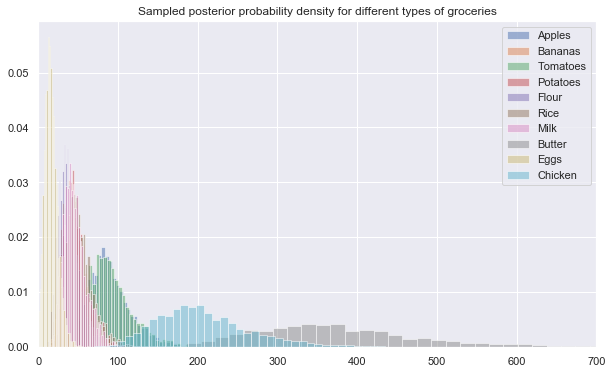

In [590]:
# the average price for each types of groceries
print(results.stansummary(pars=['base_price'], probs=[0.025, 0.5, 0.975]))

# plot the distribution of price distribution for each type of grocery
plt.figure(figsize=(10,6))
for i in range(len(grocery_dict)):
    plt.hist(posterior_samples['base_price'][:,i], bins = 50, density = True, alpha = 0.5,
            label = list(grocery_dict.keys())[i])
plt.legend()
plt.xlim((0,700))
plt.title('Sampled posterior probability density for different types of groceries')
plt.show()

## 2. Area Multiplier

Inference for Stan model: anon_model_2d72b7d429acab4beb0106c7169c8315.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
multiplier_location[1]    1.73  9.8e-3   0.27   1.26   1.71   2.31    737    1.0
multiplier_location[2]    0.91  5.1e-3   0.14   0.66    0.9   1.21    729    1.0
multiplier_location[3]    0.76  4.6e-3   0.12   0.55   0.76   1.03    726    1.0
multiplier_location[4]    0.84  4.9e-3   0.13   0.62   0.84   1.12    676    1.0
multiplier_location[5]    2.06    0.01    0.3   1.53   2.05    2.7    664    1.0
multiplier_location[6]    2.09    0.01   0.31   1.54   2.08   2.75    710    1.0
multiplier_location[7]    1.67  9.5e-3   0.25   1.23   1.65   2.21    681    1.0
multiplier_location[8]    1.84    0.01   0.28   1.33   1.82   2.42    713    1.0
multiplier_location[9]    1.82    0.01   0.27   1.35    1.8    2.4    699    1.0
m

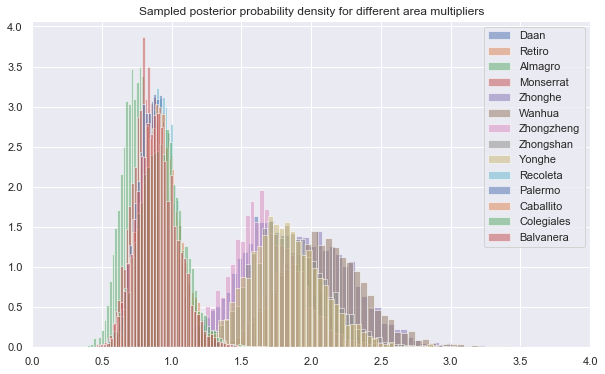

In [591]:
## the mean for each area multiplier 
print(results.stansummary(pars=['multiplier_location'], probs=[0.025, 0.5, 0.975]))

plt.figure(figsize=(10,6))
for i in range(len(area_dict)):
    plt.hist(posterior_samples['multiplier_location'][:,i], bins = 50, density = True, alpha = 0.5,
            label = list(area_dict.keys())[i])
plt.legend()
plt.xlim((0,4))
plt.title('Sampled posterior probability density for different area multipliers')
plt.show()

## 3. Store Multiplier

Inference for Stan model: anon_model_2d72b7d429acab4beb0106c7169c8315.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
multiplier_store[1]   2.27    0.03   0.62    1.3   2.19   3.69    544    1.0
multiplier_store[2]   1.73    0.02   0.46   0.99   1.67   2.79    510    1.0
multiplier_store[3]   1.91    0.02   0.51   1.09   1.86   3.11    523    1.0
multiplier_store[4]   1.98    0.02   0.53   1.13   1.91   3.25    513    1.0

Samples were drawn using NUTS at Tue Mar 17 18:30:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


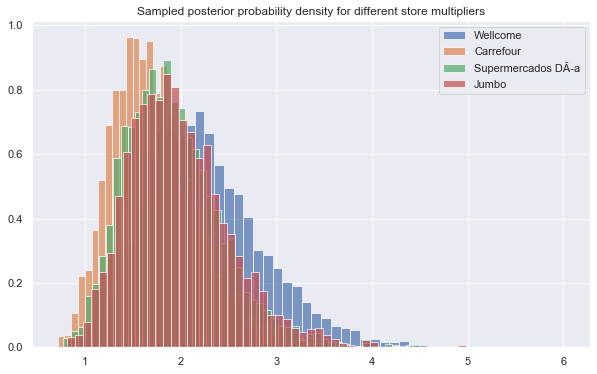

In [592]:
print(results.stansummary(pars=['multiplier_store'], probs=[0.025, 0.5, 0.975]))

plt.figure(figsize=(10,6))
for i in range(len(store_dict)):
    plt.hist(posterior_samples['multiplier_store'][:,i], bins = 50, density = True, alpha = 0.7,
            label = list(store_dict.keys())[i])
plt.legend()
plt.title('Sampled posterior probability density for different store multipliers')
plt.show()

# Relationship of Area Multilier with Rental Prices

Text(0.5, 1.0, 'Scatter plot of Area Multiplier Factor and Mean Area Rental Prices in BA')

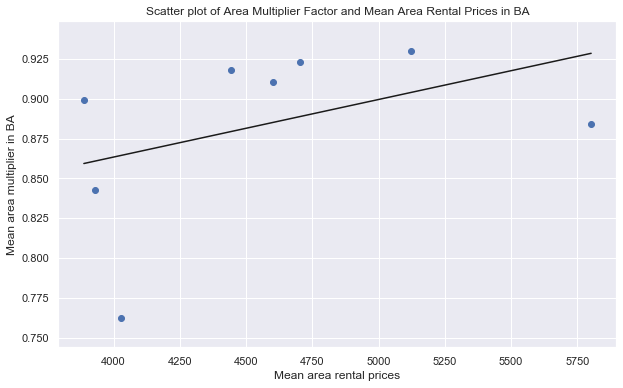

In [596]:
#BA Reantal Prices input mannully by selecting all rental prices near mentro stations within the neighborhood
Retiro = [4600]
Almagro = [4260,3750,4080]
Monserrat = [4060,3870,3860]
Recoleta = [5055,4600,4457]
Palermo = [5633,6050,5720]
Caballito = [4600,4325,4400]
Colegiales = [5121]
Balvanera = [3850,3880,4250,4025,3580,3750]
# the average rental price for each neighborhood
rental_prices = [np.mean(Retiro),np.mean(Almagro),np.mean(Monserrat),np.mean(Recoleta),np.mean(Palermo),
                 np.mean(Caballito), np.mean(Colegiales),np.mean(Balvanera)]
multipliers = posterior_samples['multiplier_location'].mean(axis=0)
# select the area multipliers for BA
BA_multipliers = [multipliers[1],multipliers[2],multipliers[3],multipliers[9],
                  multipliers[10],multipliers[11],multipliers[12],multipliers[13]]
plt.figure(figsize=(10,6))
plt.scatter(rental_prices, BA_multipliers)
slope, interc, r_value, _, _ = stats.linregress(rental_prices, BA_multipliers)
x = np.linspace(min(rental_prices)-1, max(rental_prices)+1, 100)
y = slope * x + interc
plt.plot(x, y, color='k')
plt.xlabel("Mean area rental prices")
plt.ylabel("Mean area multiplier in BA")
plt.title("Scatter plot of Area Multiplier Factor and Mean Area Rental Prices in BA")
